In [1]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [16]:
import os
import ast
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets

label_list = ["O", "B-DEP", "I-DEP", "B-ARR", "I-ARR"]

path = "data/token_classification/"

# dataset dict with emtpy attribute train
dataset = DatasetDict({'train': Dataset.from_dict({})})

for file in os.listdir(path):
    if file.endswith(".csv"):
        new_data = load_dataset('csv', data_files=path + file, delimiter=';')
        dataset["train"] = concatenate_datasets([dataset["train"], new_data["train"]])

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 357696
    })
})

In [3]:
# Evaluate tokens and ner_tags as lists
dataset = dataset.map(lambda line: {'tokens': ast.literal_eval(line['tokens'])})
dataset = dataset.map(lambda line: {'ner_tags': ast.literal_eval(line['ner_tags'])})

In [4]:
# Cast ner_tags to ClassLabel with all labels present in ner_tags
from datasets import ClassLabel, Sequence

dataset = dataset.cast_column("ner_tags", Sequence(feature=ClassLabel(num_classes=len(label_list), names=label_list)))

In [5]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR'], id=None), length=-1, id=None)}

In [6]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [7]:
show_random_elements(dataset["train"])

,text,tokens,ner_tags
0,Montre-moi le chemin pour aller à Saint-Louis à partir de Clermont.,"[Montre-, moi, le, chemin, pour, aller, à, Saint-, Louis, à, partir, de, Clermont, .]","[O, O, O, O, O, O, O, B-DEP, I-DEP, O, O, O, B-ARR, O]"
1,"Serait-il possible de me rendre de perl gare db à le lardin saint lazare, s'il vous plaît ?","[Serait-, il, possible, de, me, rendre, de, perl, gare, db, à, le, lardin, saint, lazare,, s', il, vous, plaît, , .]","[O, O, O, O, O, O, O, B-DEP, I-DEP, I-DEP, O, B-ARR, I-ARR, I-ARR, I-ARR, O, O, O, O, O, O]"
2,Il participe à l'élaboration de la plupart des règles de fonctionnement de cette dernière[2].,"[Il, participe, à, l', élaboration, de, la, plupart, des, règles, de, fonctionnement, de, cette, dernière[, 2]]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,"narcisa a changé ses manières, elle a lutté au début mais lentement et patiemment elle a commencé à devenir beaucoup plus gentille un jour, mellie et terry sont venus rencontrer marian à nouveau oh bonjour à vous deux alors dites-nous marian.","[narcisa, a, changé, ses, manières,, elle, a, lutté, au, début, mais, lentement, et, patiemment, elle, a, commencé, à, devenir, beaucoup, plus, gentille, un, jour,, mellie, et, terry, sont, venus, rencontrer, marian, à, nouveau, oh, bonjour, à, vous, deux, alors, dites-, nous, marian, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,je demande et puis je dis à la fin.,"[je, demande, et, puis, je, dis, à, la, fin, .]","[O, O, O, O, O, O, O, O, O, O]"
5,"Jimmy Wales intervient fin 2005 sur l'article « Wikipedia » de Wikipédia en anglais, pour retirer l'information selon laquelle Larry Sanger en était cofondateur, puisque Sanger a toujours été un salarié.","[Jimmy, Wales, intervient, fin, 2005, sur, l', article, Wikipedia, de, Wikipédia, en, anglais,, pour, retirer, l', information, selon, laquelle, Larry, Sanger, en, était, cofondateur,, puisque, Sanger, a, toujours, été, un, salarié, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
6,Non pas du tout.,"[Non, pas, du, tout, .]","[O, O, O, O, O]"
7,Indique-moi le trajet le plus simple depuis Ingwiller vers Mommenheim.,"[Indique-, moi, le, trajet, le, plus, simple, depuis, Ingwiller, vers, Mommenheim, .]","[O, O, O, O, O, O, O, O, B-ARR, O, B-DEP, O]"
8,Dirigez-vous vers arches en partant de romilly sur seine.,"[Dirigez-, vous, vers, arches, en, partant, de, romilly, sur, seine, .]","[O, O, O, B-ARR, O, O, O, B-DEP, I-DEP, I-DEP, O]"
9,Cette idée prévaut jusqu’à l'apparition de la conception moderne de la science (Galilée).,"[Cette, idée, prévaut, jusqu’, à, l', apparition, de, la, conception, moderne, de, la, science, Galilée)]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


In [8]:
# count number of each label in ner_tags
from collections import Counter

tag_counts = Counter()
for tags in dataset['train']['ner_tags']:
    tag_counts.update(tags)
    
tag_counts = {label_list[key]: value for key, value in tag_counts.items()}
tag_counts

{'O': 6122271,
 'B-DEP': 178848,
 'I-DEP': 156492,
 'B-ARR': 178848,
 'I-ARR': 155763}

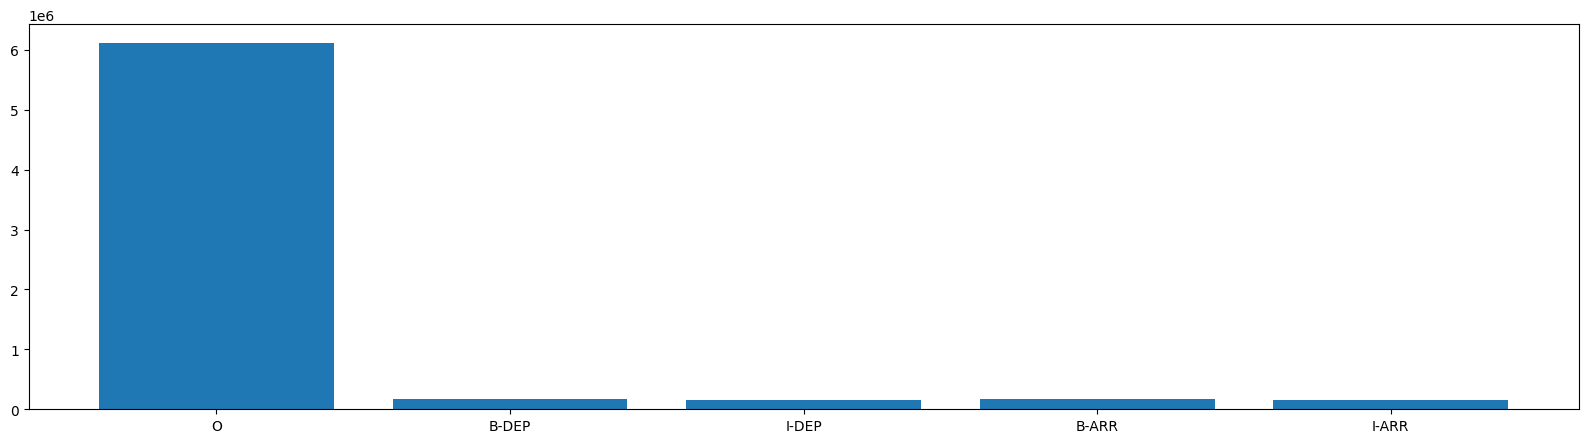

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.show()

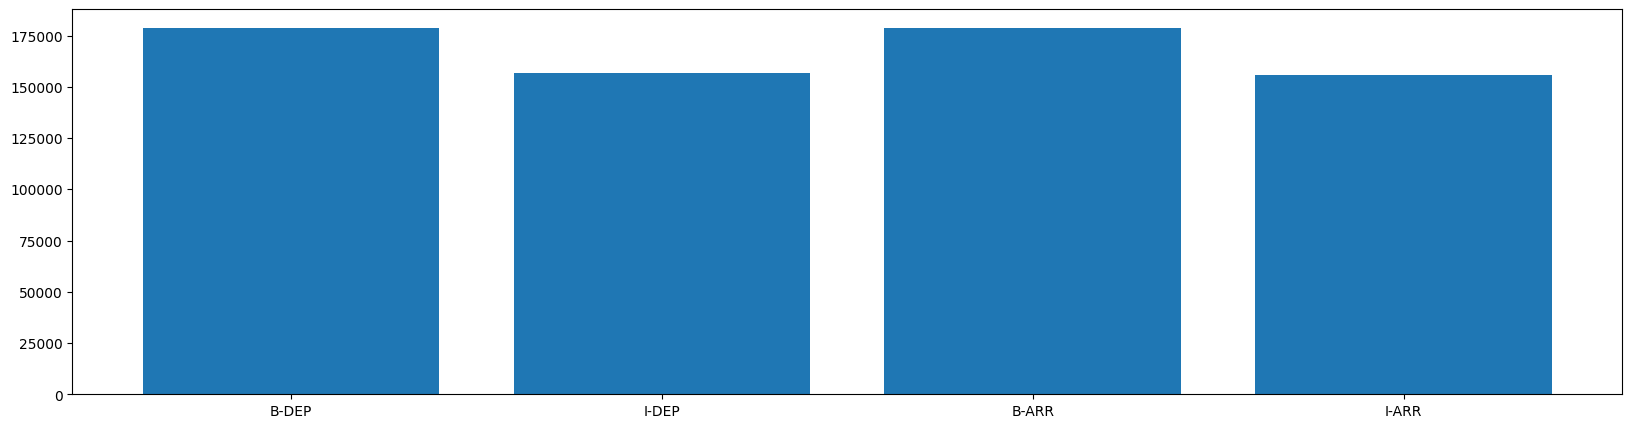

In [10]:
del tag_counts['O']
plt.figure(figsize=(20, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.show()

In [11]:
# Shuffle train dataset, and pick 50% of it
train_data = dataset['train']
train_data = train_data.shuffle(seed=42)
train_data = train_data.train_test_split(test_size=0.5)['train']

# Split test dataset into 10% validation and 10% test
train_test_valid = train_data.train_test_split(test_size=0.2)
test_valid = train_test_valid['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 143078
    })
    test: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 17885
    })
    valid: Dataset({
        features: ['text', 'tokens', 'ner_tags'],
        num_rows: 17885
    })
})

In [12]:
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "distilbert-base-uncased"

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [14]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [15]:
example = dataset["train"][0]

In [16]:
example["tokens"]

['tellement',
 "qu'",
 'ils',
 'oublient',
 'quoi',
 'faire',
 'maintenant',
 'confus',
 'a',
 'tendance',
 'à',
 'être',
 'un',
 'mot',
 'surutilisé',
 'alors',
 'au',
 'lieu',
 'de',
 'cela,',
 'pourquoi',
 "n'",
 'utilisez-',
 'vous',
 'pas',
 'flummox,',
 'par',
 'exemple,',
 'le',
 'garçon',
 'avait',
 "l'",
 'air',
 'complètement',
 'décontenancé',
 'quand',
 'le',
 'professeur',
 'lui',
 'a',
 'posé',
 'une',
 'question',
 'en',
 'classe',
 'ou',
 'que',
 'le',
 'chien',
 'était',
 'décontenancé',
 'à',
 'son',
 'propre',
 'reflet',
 'dans',
 'le',
 'miroir',
 'ou',
 'le',
 'touriste',
 'a',
 'été',
 'étonné',
 'par',
 'les',
 'différentes',
 'coutumes',
 'qui',
 '.']

In [17]:
tokenizer(example["tokens"], is_split_into_words=True)

{'input_ids': [101, 2425, 13665, 24209, 1005, 6335, 2015, 15068, 16558, 11638, 22035, 2072, 4189, 2063, 2364, 6528, 4630, 9530, 25608, 1037, 7166, 6651, 1037, 3802, 2890, 4895, 9587, 2102, 7505, 21823, 6856, 2063, 2632, 5668, 8740, 22470, 2139, 8292, 2721, 1010, 10364, 28940, 10448, 1050, 1005, 21183, 24411, 9351, 1011, 29536, 2271, 14674, 19857, 7382, 11636, 1010, 11968, 4654, 6633, 10814, 1010, 3393, 11721, 29566, 2078, 10927, 4183, 1048, 1005, 2250, 3143, 3672, 21933, 10111, 7229, 3401, 24110, 2094, 3393, 11268, 7971, 11236, 11320, 2072, 1037, 13382, 16655, 3160, 4372, 2465, 2063, 15068, 10861, 3393, 9610, 2368, 27859, 4183, 21933, 10111, 7229, 3401, 1037, 2365, 17678, 2890, 25416, 7485, 18033, 3393, 14719, 21165, 15068, 3393, 7538, 2063, 1037, 3802, 2063, 21687, 2638, 11968, 4649, 2367, 2229, 2522, 4904, 17897, 2015, 21864, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [18]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'tell',
 '##ement',
 'qu',
 "'",
 'il',
 '##s',
 'ou',
 '##bl',
 '##ient',
 'quo',
 '##i',
 'fair',
 '##e',
 'main',
 '##ten',
 '##ant',
 'con',
 '##fus',
 'a',
 'tend',
 '##ance',
 'a',
 'et',
 '##re',
 'un',
 'mo',
 '##t',
 'sur',
 '##uti',
 '##lis',
 '##e',
 'al',
 '##ors',
 'au',
 'lieu',
 'de',
 'ce',
 '##la',
 ',',
 'pour',
 '##qu',
 '##oi',
 'n',
 "'",
 'ut',
 '##ilis',
 '##ez',
 '-',
 'vo',
 '##us',
 'pas',
 'flu',
 '##mm',
 '##ox',
 ',',
 'par',
 'ex',
 '##em',
 '##ple',
 ',',
 'le',
 'ga',
 '##rco',
 '##n',
 'ava',
 '##it',
 'l',
 "'",
 'air',
 'complete',
 '##ment',
 'deco',
 '##nte',
 '##nan',
 '##ce',
 'quan',
 '##d',
 'le',
 'prof',
 '##ess',
 '##eur',
 'lu',
 '##i',
 'a',
 'pose',
 'une',
 'question',
 'en',
 'class',
 '##e',
 'ou',
 'que',
 'le',
 'chi',
 '##en',
 'eta',
 '##it',
 'deco',
 '##nte',
 '##nan',
 '##ce',
 'a',
 'son',
 'prop',
 '##re',
 'ref',
 '##let',
 'dans',
 'le',
 'mir',
 '##oir',
 'ou',
 'le',
 'tourist',
 '##e',
 'a',
 'et',
 '##e',
 'eto

In [19]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example[f"{task}_tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

132 132


In [20]:
label_all_tokens = True

In [21]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [22]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/143078 [00:00<?, ? examples/s]

Map:   0%|          | 0/17885 [00:00<?, ? examples/s]

Map:   0%|          | 0/17885 [00:00<?, ? examples/s]

In [23]:
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in id2label.items()}

In [24]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
batch_size = 16
epochs = 3
metric_name = "f1"

In [26]:
args = TrainingArguments(
    f"models/distilbert-finetuned-token-classification-ner-trip",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    #push_to_hub=True,
)

In [27]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [28]:
from datasets import load_metric

metric = load_metric("seqeval")

C:\Users\Eliott Clavier\AppData\Local\Temp\ipykernel_17264\3417332866.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [29]:
labels = [label_list[i] for i in example[f"{task}_tags"]]
metric.compute(predictions=[labels], references=[labels])

C:\Developpement\environments\nlp\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Developpement\environments\nlp\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Developpement\environments\nlp\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Developpement\environments\nlp\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 1.0}

In [30]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


Checkpoint destination directory models/distilbert-finetuned-token-classification-ner-trip\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-finetuned-token-classification-ner-trip\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-finetuned-token-classification-ner-trip\checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-finetuned-token-classification-ner-trip\checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory models/distilbert-finetuned-token-classification-ner-trip\checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory mod

TrainOutput(global_step=26829, training_loss=0.008104283635751112, metrics={'train_runtime': 1910.323, 'train_samples_per_second': 224.692, 'train_steps_per_second': 14.044, 'total_flos': 1.0484057556954828e+16, 'train_loss': 0.008104283635751112, 'epoch': 3.0})

In [33]:
trainer.save_model("models/distilbert-finetuned-token-classification-ner-trip")

In [34]:
trainer.evaluate()

{'eval_loss': 0.0022704906295984983,
 'eval_precision': 0.9926369075011505,
 'eval_recall': 0.9931978484271332,
 'eval_f1': 0.9929172987393421,
 'eval_accuracy': 0.9992134194303693,
 'eval_runtime': 25.8485,
 'eval_samples_per_second': 691.917,
 'eval_steps_per_second': 43.252,
 'epoch': 3.0}

In [35]:
predictions, labels, _ = trainer.predict(tokenized_datasets["valid"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'ARR': {'precision': 0.9935897435897436,
  'recall': 0.9921443118999127,
  'f1': 0.9928665016741883,
  'number': 24059},
 'DEP': {'precision': 0.9916743755781684,
  'recall': 0.9942664418212479,
  'f1': 0.9929687171066481,
  'number': 23720},
 'overall_precision': 0.9926369075011505,
 'overall_recall': 0.9931978484271332,
 'overall_f1': 0.9929172987393421,
 'overall_accuracy': 0.9992134194303693}

In [36]:
train_metrics = trainer.evaluate(tokenized_datasets["train"])
validation_metrics = trainer.evaluate(tokenized_datasets["valid"])

In [51]:
def gather_outputs(outputs: list) -> list:
    # Group entities by their sequence
    grouped_entities = []
    current_group = []
    for entity in outputs:
        if not current_group or entity['start'] == current_group[-1]['end']:
            current_group.append(entity)
        else:
            grouped_entities.append(current_group)
            current_group = [entity]
    
    # Append the last group
    if current_group:
        grouped_entities.append(current_group)
    
    return grouped_entities

def get_locations_from_outputs(sentence: str, outputs: list) -> list:
    groups = gather_outputs(outputs)
    groups = [{"group": group[0]["entity_group"], "city": sentence[group[0]["start"]:group[-1]["end"]] } for group in groups]
    
    # if there is more than one of the same entity group, return groups
    if len(set([group["group"] for group in groups])) != len(groups):
        return groups
    
    return sorted(groups, key=lambda group: group["group"], reverse=True)

In [52]:
from transformers import pipeline
sentences = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck."
]

for sentence in sentences:
    token_classifier = pipeline("token-classification", model="models/distilbert-finetuned-token-classification-ner-trip", aggregation_strategy="simple")
    outputs = token_classifier(sentence)
    print(get_locations_from_outputs(sentence, outputs))

[{'group': 'DEP', 'city': 'Port-Boulet'}, {'group': 'ARR', 'city': 'Le Havre'}]
[{'group': 'DEP', 'city': "'Épierre"}, {'group': 'ARR', 'city': 'Paris'}]
[{'group': 'DEP', 'city': 'Margny-Lès-Compiègne'}, {'group': 'ARR', 'city': 'Saarbrücken'}, {'group': 'ARR', 'city': '/Sarrebruck'}]
